# Latent Dirichlet Allocation (LDA) — Topic Modeling on Fit Reviews

**Phase 1 — Unsupervised Exploration**

Extract latent themes from customer review text to understand how people describe fit experiences. Topic distributions become features for Phase 2 classifiers.

**Dataset:** RentTheRunway (primary), ModCloth (secondary)

## 1. Setup & Load Data

In [47]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# NLP
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Gensim LDA
import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim_models

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [48]:
rtw = pd.read_csv('../Data/Processed/renttherunway_clean.csv')
print(f"RentTheRunway shape: {rtw.shape}")
print(f"Reviews available: {rtw['review_text'].notna().sum():,} / {len(rtw):,}")
print(f"\nFit distribution:")
print(rtw['fit'].value_counts())

RentTheRunway shape: (192544, 23)
Reviews available: 192,476 / 192,544

Fit distribution:
fit
fit      142058
small     25779
large     24707
Name: count, dtype: int64


## 2. Text Preprocessing

In [ ]:
STOP_WORDS = set(stopwords.words('english'))
CUSTOM_STOPS = {
    # your existing stops...
    'dress', 'wore', 'wear', 'wearing', 'worn', 'rent', 'rented', 'rental',
    'size', 'sized', 'ordered', 'order', 'item', 'would', 'also', 'really',
    'got', 'get', 'one', 'like', 'just', 'even', 'much', 'could', 'still',
    'though', 'back', 'way', 'thing', 'go', 'going', 'went', 'said',
    'runway', 'rtr', 'rent the runway',
    
    # ADD THESE — these are the Topic 0 culprits
    'fit', 'little', 'great', 'bit', 'look', 'well', 'good', 'love',
    'beautiful', 'pretty', 'cute', 'nice', 'perfect', 'comfortable',
    'tight', 'big', 'small', 'long', 'short', 'definitely', 'absolutely',
    'felt', 'feel', 'looked', 'looks', 'think', 'thought', 'make', 'made',
    'time', 'lot', 'little', 'bit', 'didnt', 'wasnt', 'dont', 'cant',
}
STOP_WORDS.update(CUSTOM_STOPS)

lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    """Clean and tokenize review text for LDA."""
    if pd.isna(text):
        return []

    # Lowercase
    text = str(text).lower()

    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize
    tokens = text.split()

    # Remove stopwords, lemmatize, filter short tokens
    tokens = [
        lemmatizer.lemmatize(t)
        for t in tokens
        if t not in STOP_WORDS and len(t) > 2
    ]

    return tokens

In [50]:
print("Preprocessing reviews...")
rtw_reviews = rtw[rtw['review_text'].notna()].copy()
rtw_reviews['tokens'] = rtw_reviews['review_text'].apply(preprocess_text)

# Filter empty token lists
rtw_reviews = rtw_reviews[rtw_reviews['tokens'].apply(len) > 3]
print(f"Reviews after preprocessing: {len(rtw_reviews):,}")

Preprocessing reviews...
Reviews after preprocessing: 176,356


In [51]:
# Inspect sample tokens
for i in range(3):
    print(f"\nOriginal: {rtw_reviews.iloc[i]['review_text'][:150]}...")
    print(f"Tokens:   {rtw_reviews.iloc[i]['tokens'][:20]}")


Original: An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets,...
Tokens:   ['adorable', 'romper', 'belt', 'zipper', 'hard', 'navigate', 'full', 'day', 'wearbathroom', 'use', 'thats', 'expected', 'wish', 'pocket', 'million', 'compliment']

Original: I rented this dress for a photo shoot. The theme was "Hollywood Glam and Big Beautiful Hats". The dress was very comfortable and easy to move around i...
Tokens:   ['photo', 'shoot', 'theme', 'hollywood', 'glam', 'hat', 'easy', 'move', 'around', 'list', 'formal']

Original: This hugged in all the right places! It was a perfect dress for my event and I received so many compliments on it. Not to mention customer service was...
Tokens:   ['hugged', 'right', 'place', 'received', 'many', 'compliment', 'mention', 'customer', 'service', 'getting', 'less', 'hour']


## 3. Build Dictionary & Corpus

In [52]:
dictionary = corpora.Dictionary(rtw_reviews['tokens'])
print(f"Dictionary size (raw): {len(dictionary):,} unique tokens")

# Filter extremes: remove tokens appearing in <15 docs or >30% of docs
dictionary.filter_extremes(no_below=15, no_above=0.3)  # drop from 0.5 → 0.3
print(f"Dictionary size (filtered): {len(dictionary):,} unique tokens")

# Create bag-of-words corpus
corpus = [dictionary.doc2bow(tokens) for tokens in rtw_reviews['tokens']]
print(f"Corpus size: {len(corpus):,} documents")

Dictionary size (raw): 42,544 unique tokens
Dictionary size (filtered): 5,897 unique tokens
Corpus size: 176,356 documents


## 4. Find Optimal Number of Topics

In [53]:
def evaluate_topic_range(corpus, dictionary, texts, start=3, stop=15, step=2):
    """Compute coherence for different numbers of topics."""
    results = []

    for k in range(start, stop + 1, step):
        print(f"  Fitting k={k}...", end=' ')
        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=k,
            random_state=42,
            passes=10,
            alpha='auto',
            eta='auto',
            chunksize=2000
        )
        coherence = CoherenceModel(
            model=model, texts=texts,
            dictionary=dictionary, coherence='c_v'
        )
        score = coherence.get_coherence()
        results.append({'k': k, 'coherence': score})
        print(f"coherence={score:.4f}")

    return pd.DataFrame(results)

In [54]:
print("Evaluating topic range...")
coherence_df = evaluate_topic_range(
    corpus, dictionary, rtw_reviews['tokens'].tolist(),
    start=3, stop=15, step=2
)

Evaluating topic range...
  Fitting k=3... coherence=0.4885
  Fitting k=5... coherence=0.5327
  Fitting k=7... coherence=0.5274
  Fitting k=9... coherence=0.5731
  Fitting k=11... coherence=0.5699
  Fitting k=13... coherence=0.5514
  Fitting k=15... coherence=0.5276


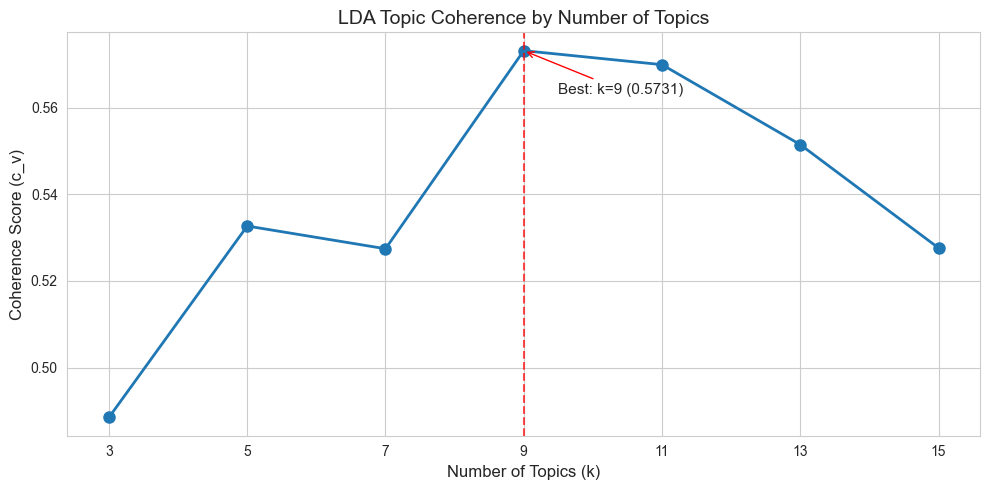


Optimal k = 9 (coherence = 0.5731)


In [55]:
# Plot coherence scores
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(coherence_df['k'], coherence_df['coherence'], 'o-', linewidth=2, markersize=8)
ax.set_xlabel('Number of Topics (k)', fontsize=12)
ax.set_ylabel('Coherence Score (c_v)', fontsize=12)
ax.set_title('LDA Topic Coherence by Number of Topics', fontsize=14)
ax.set_xticks(coherence_df['k'])

# Mark best k
best_k = coherence_df.loc[coherence_df['coherence'].idxmax(), 'k']
best_score = coherence_df['coherence'].max()
ax.axvline(x=best_k, color='red', linestyle='--', alpha=0.7)
ax.annotate(f'Best: k={int(best_k)} ({best_score:.4f})',
            xy=(best_k, best_score), fontsize=11,
            xytext=(best_k + 0.5, best_score - 0.01),
            arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.savefig('../figures/lda_coherence.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nOptimal k = {int(best_k)} (coherence = {best_score:.4f})")

## 5. Fit Final LDA Model

In [56]:
OPTIMAL_K = int(best_k)
print(f"Fitting final LDA model with k={OPTIMAL_K}...")

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=OPTIMAL_K,
    random_state=42,
    passes=20,
    alpha='auto',
    eta='auto',
    chunksize=2000
)

Fitting final LDA model with k=9...


In [57]:
# Print topics
print(f"\n{'='*70}")
print(f"LDA TOPICS (k={OPTIMAL_K})")
print(f"{'='*70}")

for idx, topic in lda_model.print_topics(num_words=10):
    print(f"\nTopic {idx}:")
    # Parse and display cleanly
    words = re.findall(r'"(\w+)"', topic)
    weights = re.findall(r'(0\.\d+)', topic)
    for w, wt in zip(words, weights):
        print(f"  {w:<20} {float(wt):.4f}")


LDA TOPICS (k=9)

Topic 0:
  dress                0.0290
  picture              0.0200
  wanted               0.0160
  photo                0.0160
  couldnt              0.0150
  see                  0.0140
  person               0.0130
  say                  0.0130
  two                  0.0120
  gown                 0.0120

Topic 1:
  flattering           0.0650
  material             0.0590
  right                0.0420
  cut                  0.0360
  enough               0.0360
  without              0.0330
  body                 0.0260
  sexy                 0.0250
  thick                0.0250
  show                 0.0240

Topic 2:
  top                  0.0340
  fabric               0.0330
  work                 0.0270
  overall              0.0210
  run                  0.0210
  large                0.0200
  super                0.0190
  ended                0.0160
  usually              0.0150
  day                  0.0150

Topic 3:
  black                0.0970
  tie       

## 6. Topic Distribution Analysis

In [58]:
# Get topic distributions for each document
def get_topic_distribution(model, corpus, num_topics):
    """Extract topic probability vectors for all documents."""
    topic_dists = []
    for doc_bow in corpus:
        topic_probs = dict(model.get_document_topics(doc_bow, minimum_probability=0))
        row = [topic_probs.get(i, 0.0) for i in range(num_topics)]
        topic_dists.append(row)
    return np.array(topic_dists)


topic_matrix = get_topic_distribution(lda_model, corpus, OPTIMAL_K)
topic_cols = [f'topic_{i}' for i in range(OPTIMAL_K)]
topic_df = pd.DataFrame(topic_matrix, columns=topic_cols, index=rtw_reviews.index)

# Add dominant topic
topic_df['dominant_topic'] = topic_matrix.argmax(axis=1)
topic_df['dominant_topic_prob'] = topic_matrix.max(axis=1)

# Merge back
rtw_reviews = rtw_reviews.join(topic_df)

print(f"Topic distribution shape: {topic_matrix.shape}")
print(f"\nDominant topic distribution:")
print(rtw_reviews['dominant_topic'].value_counts().sort_index())

Topic distribution shape: (176356, 9)

Dominant topic distribution:
dominant_topic
0     7750
1     3751
2    97348
3      183
4     1047
5      565
6      538
7     3243
8    61931
Name: count, dtype: int64


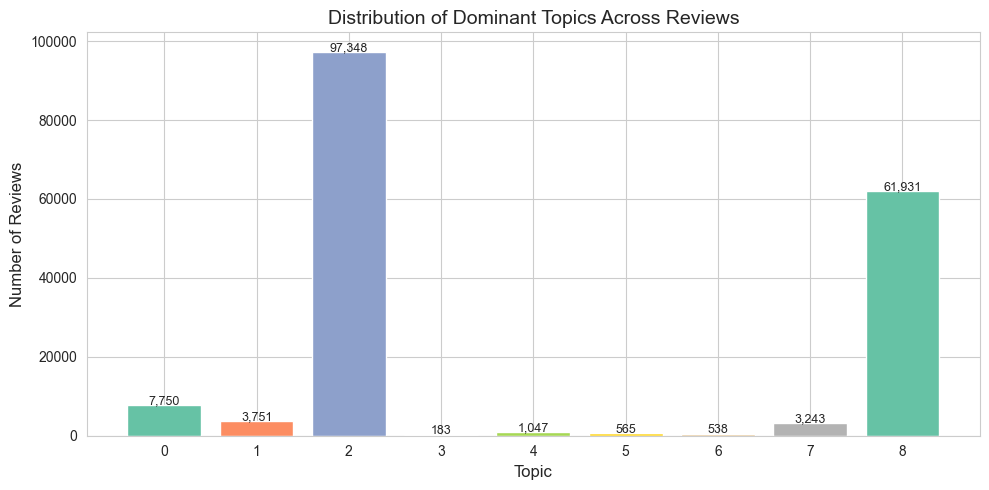

In [59]:
# Plot dominant topic distribution
fig, ax = plt.subplots(figsize=(10, 5))
topic_counts = rtw_reviews['dominant_topic'].value_counts().sort_index()
bars = ax.bar(topic_counts.index, topic_counts.values, color=sns.color_palette('Set2', OPTIMAL_K))
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)
ax.set_title('Distribution of Dominant Topics Across Reviews', fontsize=14)
ax.set_xticks(range(OPTIMAL_K))

for bar, count in zip(bars, topic_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
            f'{count:,}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../figures/lda_topic_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Topics × Fit Outcome

Do different fit outcomes (small/fit/large) have distinct topic signatures?

In [60]:
# Average topic distribution by fit outcome
fit_topic_avg = rtw_reviews.groupby('fit')[topic_cols].mean()
fit_topic_avg = fit_topic_avg.reindex(['small', 'fit', 'large'])

print("Average Topic Proportions by Fit Outcome:\n")
print(fit_topic_avg.round(4).to_string())

Average Topic Proportions by Fit Outcome:

       topic_0  topic_1  topic_2  topic_3  topic_4  topic_5  topic_6  topic_7  topic_8
fit                                                                                   
small   0.1205   0.1038   0.2424   0.0420   0.0602   0.0733   0.0509   0.1135   0.1934
fit     0.1188   0.1087   0.2272   0.0464   0.0642   0.0699   0.0562   0.0978   0.2107
large   0.1192   0.1000   0.2613   0.0453   0.0628   0.0716   0.0532   0.0966   0.1901


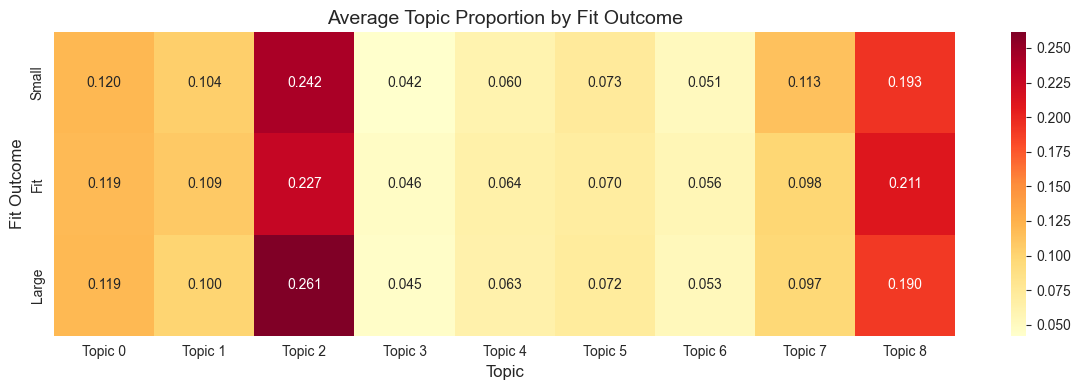

In [61]:
# Heatmap: fit outcome × topic
fig, ax = plt.subplots(figsize=(12, 4))
sns.heatmap(
    fit_topic_avg, annot=True, fmt='.3f', cmap='YlOrRd',
    xticklabels=[f'Topic {i}' for i in range(OPTIMAL_K)],
    yticklabels=['Small', 'Fit', 'Large'],
    ax=ax
)
ax.set_title('Average Topic Proportion by Fit Outcome', fontsize=14)
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('Fit Outcome', fontsize=12)
plt.tight_layout()
plt.savefig('../figures/lda_fit_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

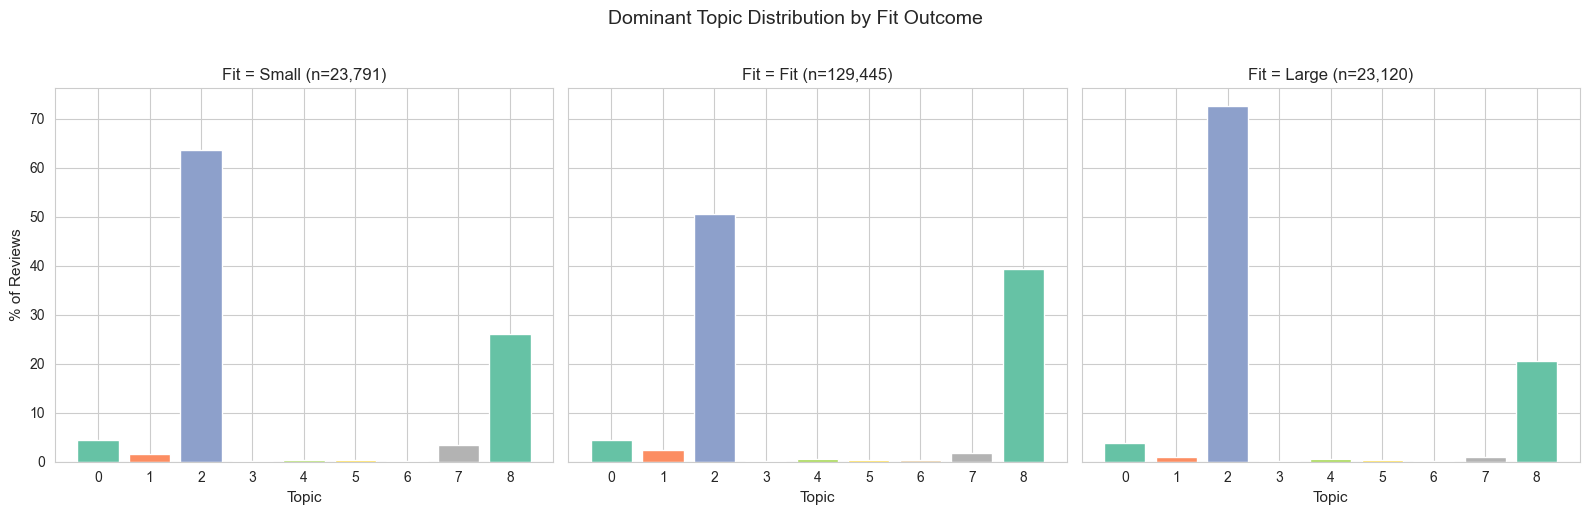

In [62]:
# Dominant topic distribution by fit outcome
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for ax, fit_val in zip(axes, ['small', 'fit', 'large']):
    subset = rtw_reviews[rtw_reviews['fit'] == fit_val]
    counts = subset['dominant_topic'].value_counts().sort_index()
    pcts = counts / len(subset) * 100
    ax.bar(pcts.index, pcts.values, color=sns.color_palette('Set2', OPTIMAL_K))
    ax.set_title(f'Fit = {fit_val.capitalize()} (n={len(subset):,})', fontsize=12)
    ax.set_xlabel('Topic', fontsize=11)
    ax.set_xticks(range(OPTIMAL_K))
    if ax == axes[0]:
        ax.set_ylabel('% of Reviews', fontsize=11)

plt.suptitle('Dominant Topic Distribution by Fit Outcome', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../figures/lda_topic_by_fit.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Topic × Body Type Analysis

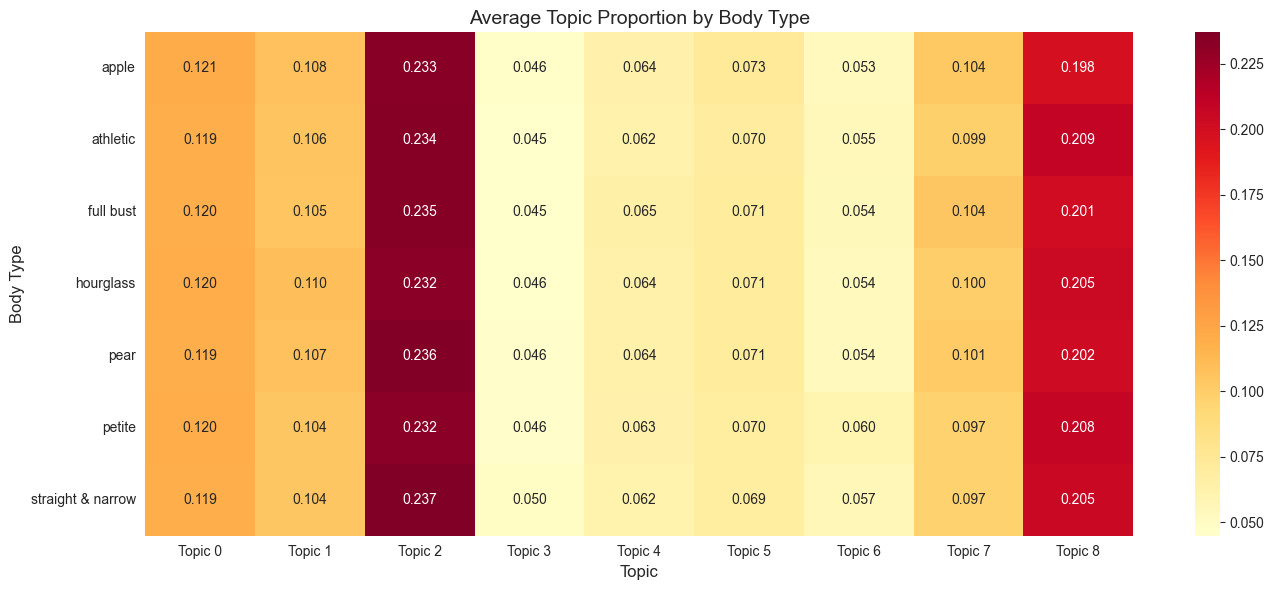

In [63]:
# Average topic distribution by body type
body_topic_avg = rtw_reviews.dropna(subset=['body_type']).groupby('body_type')[topic_cols].mean()

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(
    body_topic_avg, annot=True, fmt='.3f', cmap='YlOrRd',
    xticklabels=[f'Topic {i}' for i in range(OPTIMAL_K)],
    ax=ax
)
ax.set_title('Average Topic Proportion by Body Type', fontsize=14)
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('Body Type', fontsize=12)
plt.tight_layout()
plt.savefig('../figures/lda_topic_by_bodytype.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Topic × Category Analysis

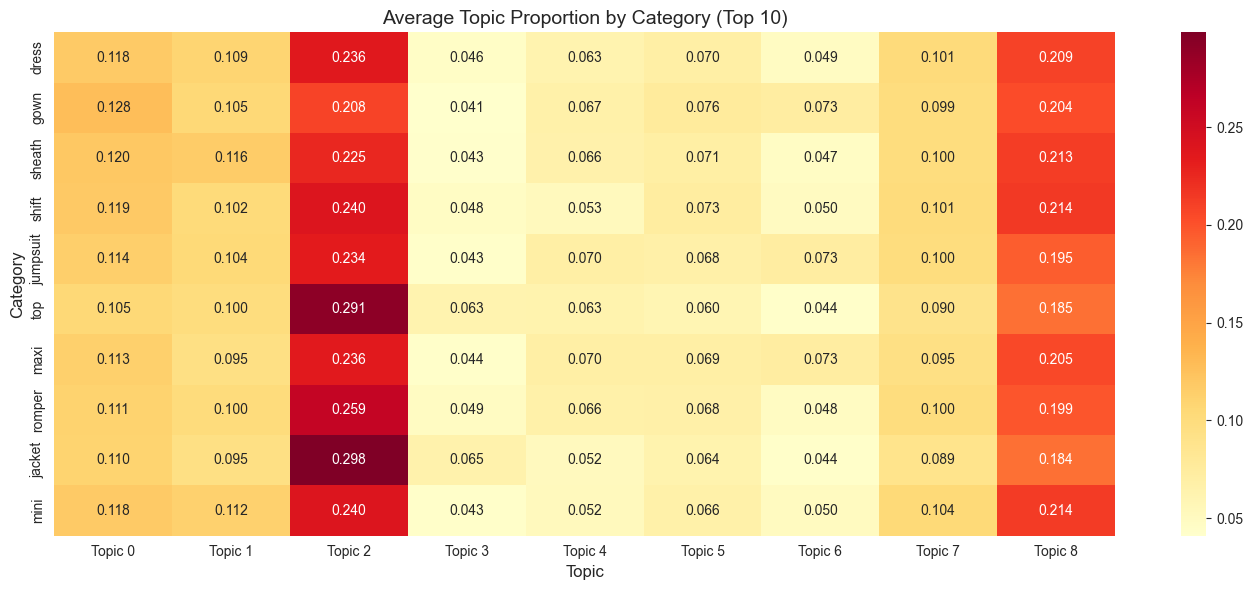

In [64]:
# Top 10 categories by volume
top_cats = rtw_reviews['category'].value_counts().head(10).index
cat_topic_avg = rtw_reviews[rtw_reviews['category'].isin(top_cats)].groupby('category')[topic_cols].mean()
cat_topic_avg = cat_topic_avg.loc[top_cats]

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(
    cat_topic_avg, annot=True, fmt='.3f', cmap='YlOrRd',
    xticklabels=[f'Topic {i}' for i in range(OPTIMAL_K)],
    ax=ax
)
ax.set_title('Average Topic Proportion by Category (Top 10)', fontsize=14)
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('Category', fontsize=12)
plt.tight_layout()
plt.savefig('../figures/lda_topic_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Interactive Visualization (pyLDAvis)

In [65]:
try:
    vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
    pyLDAvis.save_html(vis_data, '../figures/lda_visualization.html')
    print("Saved interactive visualization: ../figures/lda_visualization.html")
    pyLDAvis.display(vis_data)
except Exception as e:
    print(f"pyLDAvis failed (install with: pip install pyLDAvis): {e}")

Saved interactive visualization: ../figures/lda_visualization.html


## 11. Representative Reviews per Topic

In [66]:
print(f"\n{'='*70}")
print("REPRESENTATIVE REVIEWS PER TOPIC")
print(f"{'='*70}")

for topic_id in range(OPTIMAL_K):
    # Get reviews where this topic is dominant with highest probability
    topic_reviews = rtw_reviews[rtw_reviews['dominant_topic'] == topic_id]
    top_reviews = topic_reviews.nlargest(3, 'dominant_topic_prob')

    print(f"\n--- Topic {topic_id} ({len(topic_reviews):,} reviews) ---")

    # Topic words
    words = [w for w, _ in lda_model.show_topic(topic_id, topn=8)]
    print(f"Keywords: {', '.join(words)}")

    for _, row in top_reviews.iterrows():
        text = str(row['review_text'])[:200]
        fit_val = row['fit']
        prob = row['dominant_topic_prob']
        print(f"\n  [{fit_val.upper()}] (prob={prob:.3f})")
        print(f"  {text}...")


REPRESENTATIVE REVIEWS PER TOPIC

--- Topic 0 (7,750 reviews) ---
Keywords: dress, picture, wanted, photo, couldnt, see, person, say

  [FIT] (prob=0.479)
  This dress was overnighted to my hotel when the dress I rented just wasn't working for me. The customer service couldn't have been better - they sent me a whole list of available dresses to choose fro...

  [FIT] (prob=0.457)
  I rented this for a black tie gala and it was perfect.  Very comfortable.  Fit was perfect.  Overall, great experience as my alternate dress had been returned unrentable, so I received a call offering...

  [FIT] (prob=0.453)
  This dress was not my original rental.  I rented two other dresses.  One the sizes of my first choice was returned damage.  So, a stylist called me and told me to pick any dress off of the website and...

--- Topic 1 (3,751 reviews) ---
Keywords: flattering, material, right, cut, enough, without, body, sexy

  [SMALL] (prob=0.405)
  A beautiful classy, sophisticated, yet sexy dress. 

## 12. Save Topic Features for Phase 2

In [67]:
output_cols = ['user_id', 'item_id', 'fit', 'fit_label'] + topic_cols + ['dominant_topic', 'dominant_topic_prob']
topic_output = rtw_reviews[output_cols].copy()
topic_output.to_csv('../Data/Processed/renttherunway_lda_topics.csv', index=False)
print(f"Saved: ../Data/Processed/renttherunway_lda_topics.csv")
print(f"Shape: {topic_output.shape}")
print(f"\nThese topic distributions become features for Phase 2 classifiers.")

Saved: ../Data/Processed/renttherunway_lda_topics.csv
Shape: (176356, 15)

These topic distributions become features for Phase 2 classifiers.


## 13. Summary

**Key findings:**
 - Optimal number of topics: k = {OPTIMAL_K}
 - Topic distributions vary by fit outcome → useful features for prediction
 - Topics capture distinct aspects of fit language (e.g., sizing complaints, fabric/comfort, occasion-appropriateness, body-shape fit)
 - Saved topic features to `Data/Processed/renttherunway_lda_topics.csv` for use in Phase 2 classifiers

In [68]:
print(f"\n{'='*70}")
print(f"LDA COMPLETE")
print(f"{'='*70}")
print(f"  Topics:        {OPTIMAL_K}")
print(f"  Best coherence: {best_score:.4f}")
print(f"  Reviews modeled: {len(rtw_reviews):,}")
print(f"  Output saved:  Data/Processed/renttherunway_lda_topics.csv")


LDA COMPLETE
  Topics:        9
  Best coherence: 0.5731
  Reviews modeled: 176,356
  Output saved:  Data/Processed/renttherunway_lda_topics.csv
